In [31]:
import numpy as np
import pandas as pd
from funkcje.main_05_wczytanie_csv import wczytaj_main
from funkcje.pandas_to_markdown import pd_to_markdown
csv_path = "/media/tmakowski/Dysk/dane_csv"

In [32]:
users = wczytaj_main(
    input_path=csv_path,
    typ_pliku="Users",
    kolumny=["AccountId", "Id"]
)

Zaczynamy!


100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Gotowe! Zajęło nam to: 32.5s


In [33]:
posts = wczytaj_main(
    input_path=csv_path,
    typ_pliku="Posts",
    kolumny=["Id", "PostTypeId", "AcceptedAnswerId", "OwnerUserId"]
)

Zaczynamy!


100%|██████████| 10/10 [00:09<00:00,  1.07s/it]


Gotowe! Zajęło nam to: 108.8s


In [34]:
# pytania, które mają odpowiedzi - rzutujemy na inty, bo coś się nie spinało
pytania = (posts.query("(PostTypeId==1) and (AcceptedAnswerId.isnull() == False)").astype({"AcceptedAnswerId": np.int64})
           .rename(columns={"OwnerUserId": "Pytający"})) 

odpowiedzi = (posts.query("PostTypeId==2").astype({"Id": np.int64})
             .rename(columns={"OwnerUserId": "Odpowiadający"})).drop(columns="AcceptedAnswerId")

In [35]:
pd_to_markdown(pytania.sample(n=3))

| Id     | PostTypeId | AcceptedAnswerId | Pytający | Forum       |
|--------|------------|------------------|----------|-------------|
| 473    | 1          | 497              | 167.0    | ethereum    |
| 225259 | 1          | 225281           | 37433.0  | gis         |
| 20843  | 1          | 20855            | 10711.0  | linguistics |


In [36]:
pd_to_markdown(odpowiedzi.sample(n=3))

| Id      | PostTypeId | Odpowiadający | Forum     |
|---------|------------|---------------|-----------|
| 66792   | 2          | 17450.0       | tex       |
| 321463  | 2          | 1492.0        | physics   |
| 1366456 | 2          | 953530.0      | superuser |


In [37]:
pytacze_odpowiadacze = pd.merge(
    left=pytania, 
    right=odpowiedzi,
    left_on=["Forum", "AcceptedAnswerId"],
    right_on=["Forum", "Id"]
).loc[:, ["Pytający", "Odpowiadający", "Forum"]]
# pytacze_odpowiadacze.head()

In [38]:
pd_to_markdown(pytacze_odpowiadacze.sample(n=3, random_state=58))

| Pytający | Odpowiadający | Forum  |
|----------|---------------|--------|
| 91583.0  | 142322.0      | gaming |
| 111655.0 | 111657.0      | ux     |
| 28463.0  | 52344.0       | dba    |


In [39]:
acc_pytacze = pd.merge(
    left=pytacze_odpowiadacze,
    right=users,
    left_on=["Forum", "Pytający"],
    right_on=["Forum", "Id"]
).rename(columns={"AccountId": "AccPytający"}).loc[:, ["AccPytający", "Forum", "Odpowiadający"]]
# acc_pytacze.head()

In [40]:
acc_pytacze_odpowiadacze = pd.merge(
    left=acc_pytacze,
    right=users,
    left_on=["Forum", "Odpowiadający"],
    right_on=["Forum", "Id"]
).rename(columns={"AccountId": "AccOdpowiadający"}).loc[:, ["AccPytający", "Forum", "AccOdpowiadający"]]
# acc_pytacze_odpowiadacze.head()

In [41]:
pd_to_markdown(acc_pytacze_odpowiadacze.sample(n=3, random_state=58))

| AccPytający | Forum       | AccOdpowiadający |
|-------------|-------------|------------------|
| 5581116     | devops      | 1178508          |
| 1773383.0   | security    | 61611.0          |
| 60385.0     | serverfault | 116827.0         |


## Działająca funkcja

In [42]:
def split_id(ids, kawalki):
    def chunks(l, n):
        """ Yield successive n-sized chunks from l. """
        for i in range(0, len(l), n):
            yield l[i:i + n]
            
    return chunks(ids, len(ids)//(kawalki-1))

In [43]:
# Unikatowe Id
uniq_id = acc_pytacze_odpowiadacze.AccPytający.drop_duplicates()

# Wynikowa ramka
wymiany_max = pd.DataFrame(columns=["Użytkownik1", "Użytkownik2", "LiczbaWymian"])

# W ilu iteracjach stworzyć ramkę
ile_kawalkow = 10
counter = 0 # do wyświetlania

for kawalek in split_id(uniq_id, ile_kawalkow):
    # Wypisywanie
    counter +=1
    print("\rPrzetwarzam %s/%s" % (counter, ile_kawalkow), end="")
    
    # Zapisanie wyniku bieżącej pętli
    wymiany_max = wymiany_max.append( 
        pd.merge(
            left=acc_pytacze_odpowiadacze.query("AccPytający in @kawalek"), # tylko aktualny pytacz
            right=acc_pytacze_odpowiadacze,
            left_on="AccOdpowiadający", # odpowiadacz staje się pytaczem
            right_on="AccPytający"
        ) # stąd mamy dla danego pytacza odpowiadaczy jego odpowiadaczy i pytanie, czy to się zapętla
        .query("AccPytający_x == AccOdpowiadający_y") # czy zamyka się cykl
        .groupby(["AccPytający_x", "AccOdpowiadający_x"])
        .size().reset_index()
        .rename(columns={"AccPytający_x": "Użytkownik1", "AccOdpowiadający_x": "Użytkownik2", 0: "LiczbaWymian"})
    )

print("\rKoniec!")
wymiany_max = wymiany_max.reset_index(drop=True).astype(np.int64) # uspójnienie typów (pod seaborn'a) i 

# Od razu standaryzujemy, bo czemu nie?
wymiany_max_std = wymiany_max.assign(Z=(wymiany_max.LiczbaWymian - wymiany_max.LiczbaWymian.mean())/wymiany_max.LiczbaWymian.std())

Koniec!


In [44]:
wymiany_max.head(3)

,Użytkownik1,Użytkownik2,LiczbaWymian
0,-1,-1,171396
1,1,1,361
2,1,4,1


In [45]:
pd_to_markdown(wymiany_max.sample(n=3))

| Użytkownik1 | Użytkownik2 | LiczbaWymian |
|-------------|-------------|--------------|
| 2613237     | 2613237     | 4            |
| 1098500     | 208980      | 2            |
| 1727596     | 1727596     | 1            |


In [46]:
wymiany_max_std.sort_values(by="LiczbaWymian", ascending=False).head(3)

,Użytkownik1,Użytkownik2,LiczbaWymian,Z
0,-1,-1,171396,269.979497
1894,22329,22329,53361,84.032623
75055,2823263,2823263,51984,81.863361


In [47]:
# a teraz bez onanistów
wymiany_max_std.query("Użytkownik1 != Użytkownik2").sort_values(by="LiczbaWymian", ascending=False).head(3)

,Użytkownik1,Użytkownik2,LiczbaWymian,Z
3097,41067,1057622,1716,2.673481
14866,1057622,41067,1716,2.673481
24729,5332283,2251762,1608,2.503343


### Zapisanie csv-ek

In [89]:
wykres_liczba_wymian = wymiany_max.query("Użytkownik1 <= Użytkownik2")
wykres_liczba_wymian.to_csv("dane/parka_ktora_sobie_odpowiada-wykresy1-2.csv", index=False)

In [124]:
odpowiedzi_sobie = acc_pytacze_odpowiadacze.query("AccPytający == AccOdpowiadający").groupby("Forum").size().rename("LiczbaOdpowiedzi").reset_index()
odpowiedzi_sobie.to_csv("dane/parka_ktora_sobie_odpowiada-wykres3.csv", index=False)

## Wyniki

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from funkcje.pandas_to_markdown import pd_to_markdown

### Wczytanie danych

In [3]:
csv1 = pd.read_csv("dane/parka_ktora_sobie_odpowiada-wykresy1-2.csv")
csv2 = pd.read_csv("dane/parka_ktora_sobie_odpowiada-wykres3.csv")

### Osoby, które wymieniły się odpowiedziami co najmniej raz

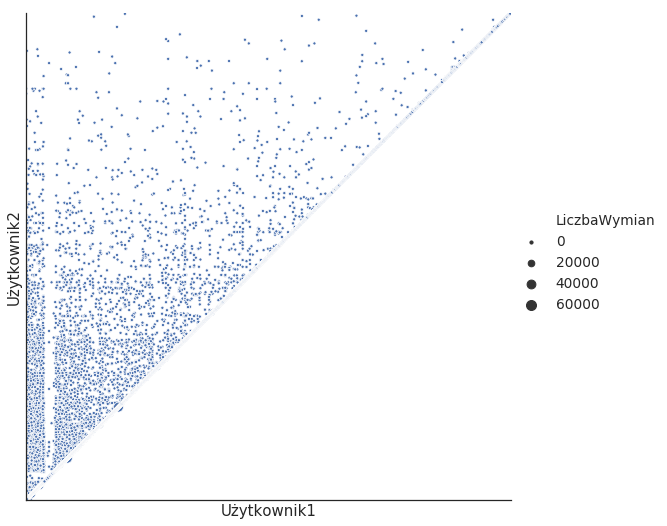

In [26]:
dane = csv1.query("Użytkownik1 != -1")

zakres = (0, max(dane.Użytkownik1.max(), dane.Użytkownik2.max()))

sns.set(style="white", font_scale=1.25)
g = sns.relplot("Użytkownik1", "Użytkownik2", size="LiczbaWymian", sizes=(10,100), data=dane, height=8).set(xticks=[], yticks=[], xlim=zakres, ylim=zakres)
plt.savefig("prezentacja/obrazki/parka_ktora_sobie_odpowiada-wykres1.png", bbox_inches="tight", dpi=600)
plt.show()

### Osoby, które wymieniły się odpowiedziami ponad 10 razy

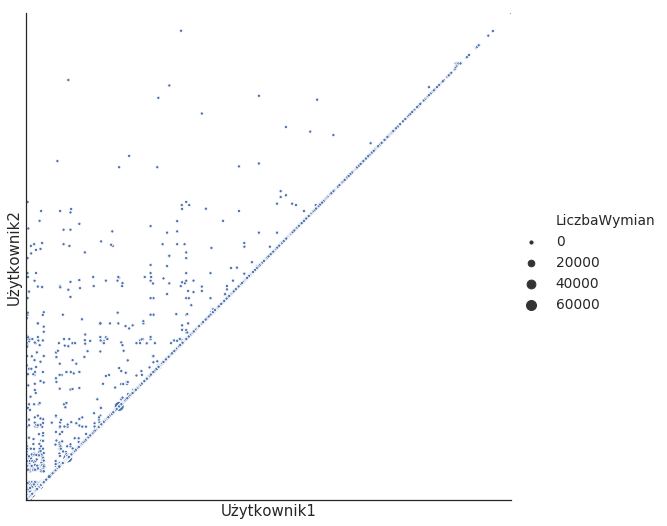

In [23]:
threshold = 10
dane = csv1.query("Użytkownik1 != -1").query("LiczbaWymian >= @threshold")

zakres = (0, max(dane.Użytkownik1.max(), dane.Użytkownik2.max()))

sns.set(style="white", font_scale=1.25)
g = sns.relplot("Użytkownik1", "Użytkownik2", size="LiczbaWymian", sizes=(10,100), data=dane, height=8).set(xticks=[], yticks=[], xlim=zakres, ylim=zakres)
plt.savefig("prezentacja/obrazki/parka_ktora_sobie_odpowiada-wykres2.png", bbox_inches="tight", dpi=600)
plt.show()

### Podsumowanie wymian

In [16]:
sami_sobie = (csv1
              .sort_values("LiczbaWymian", ascending=False)
              .query("Użytkownik1 != -1")
              .query("Użytkownik1 == Użytkownik2")
              #.drop(columns="Użytkownik2").rename(columns={"Użytkownik1": "Użytkownik", "LiczbaWymian": "LiczbaNie-Wymian"})
              .reset_index(drop=True)
              )
sami_sobie.head()

,Użytkownik1,Użytkownik2,LiczbaWymian
0,22329,22329,53361
1,2823263,2823263,51984
2,1263026,1263026,48400
3,42701,42701,47524
4,22370,22370,31329


In [14]:
sobie_nawzajem = (csv1
                  .sort_values("LiczbaWymian", ascending=False)
                  .query("Użytkownik1 != Użytkownik2")
                  .reset_index(drop=True))
sobie_nawzajem.head()

,Użytkownik1,Użytkownik2,LiczbaWymian
0,41067,1057622,1716
1,2251762,5332283,1608
2,13125839,13188116,1512
3,531452,861921,800
4,352393,5332283,800


In [15]:
sami_sobie.shape[0], sobie_nawzajem.shape[0]

(93465, 9094)

In [22]:
round(sami_sobie.LiczbaWymian.mean(), 2), round(sobie_nawzajem.LiczbaWymian.mean(), 2)

(19.63, 5.91)

In [21]:
sami_sobie.LiczbaWymian.max(), sobie_nawzajem.LiczbaWymian.max()

(53361, 1716)

### Odpowiedzi sobie

In [130]:
csv2.head()

,Forum,LiczbaOdpowiedzi
0,3dprinting,144
1,3dprinting.meta,7
2,academia,100
3,academia.meta,27
4,ai,40


#### Wykres pionowy

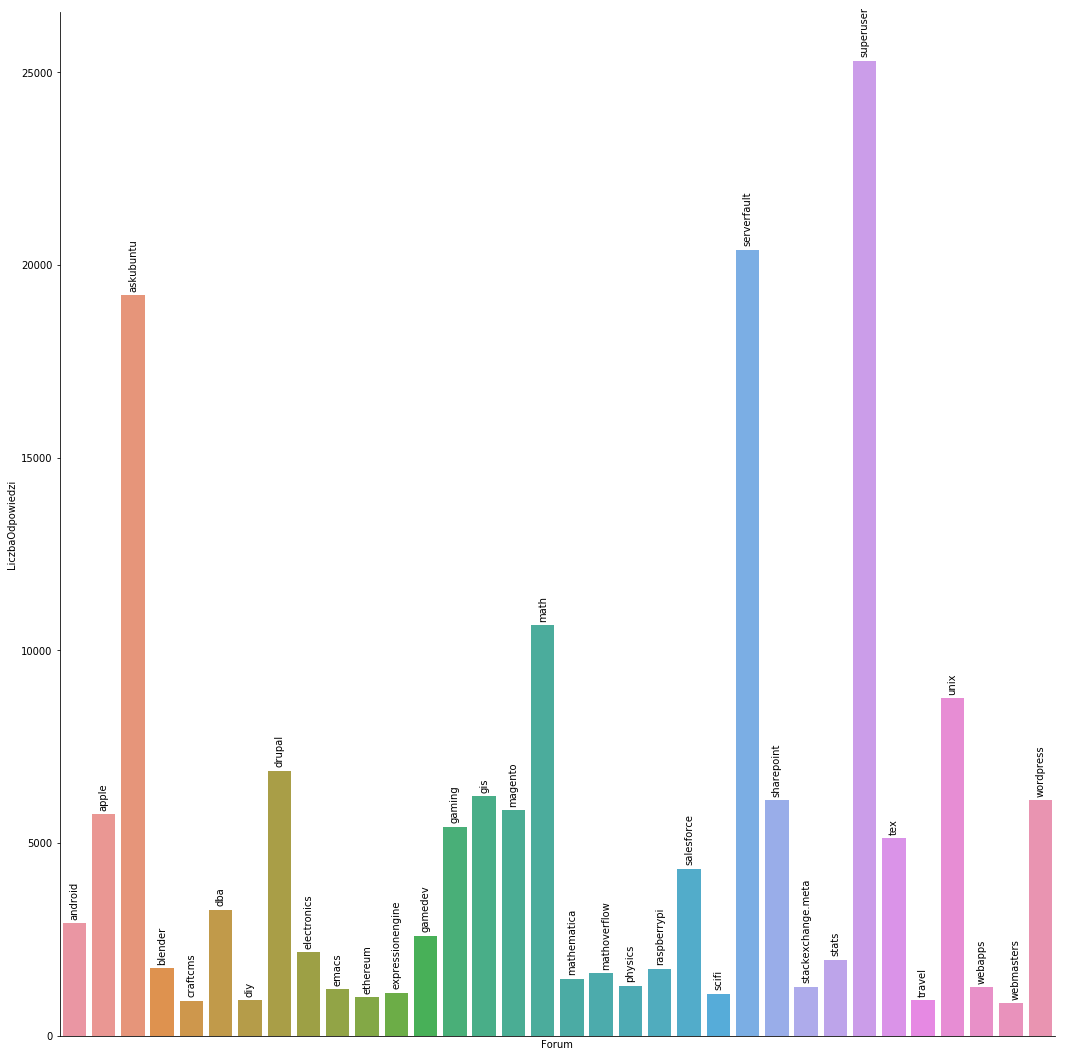

In [131]:
dane = csv2
min_postow = dane.LiczbaOdpowiedzi.quantile(0.9)
dane = dane.query("LiczbaOdpowiedzi >= @min_postow").reset_index(drop=True)

g = sns.catplot(x="Forum", y="LiczbaOdpowiedzi", data=dane, height=15, kind="bar")
g.set(xticks=[])
for index, row in dane.query("LiczbaOdpowiedzi >= @min_postow").iterrows():
    g.axes.flat[0].text(index, row.LiczbaOdpowiedzi+100, row.Forum,
                        ha="left" if row.Forum in ["mathoverflow", "webmasters"] else "center",
                        va="bottom", rotation='vertical')
# plt.savefig("prezentacja/obrazki/parka_ktora_sobie_odpowiada-wykres3_pionowy.png", bbox_inches="tight", dpi=600)
plt.show()

#### Wykres poziomy

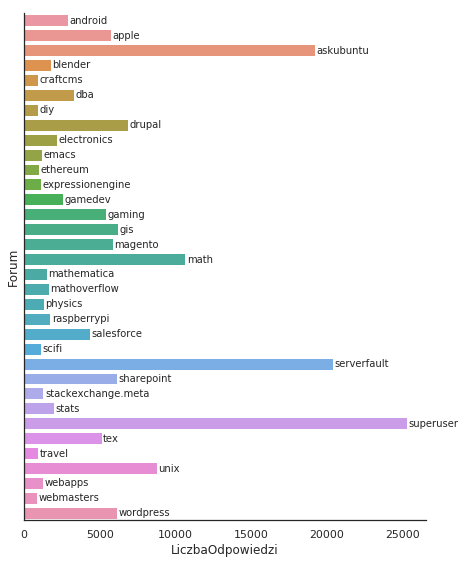

In [10]:
dane = csv2
min_postow = dane.LiczbaOdpowiedzi.quantile(0.9)
dane = dane.query("LiczbaOdpowiedzi >= @min_postow").reset_index(drop=True)

sns.set(style="white", font_scale=1.0)
g = sns.catplot(x="LiczbaOdpowiedzi", y="Forum", data=dane, height=8, kind="bar")
g.set(yticks=[])
for index, row in dane.query("LiczbaOdpowiedzi >= @min_postow").iterrows():
    g.axes.flat[0].text(row.LiczbaOdpowiedzi+100, index, row.Forum,
                        ha="left",
                        va="center", size=10)
plt.savefig("prezentacja/obrazki/parka_ktora_sobie_odpowiada-wykres3.png", bbox_inches="tight", dpi=600)
plt.show()